# Neural Model - Binaural Integration

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In this notebook we present a first implementation of a neural model for sound source elevation estimation based on the computational HRTF model. 
We use $binaural = \frac{Left}{Left + Right} $ an integration stage since it is more biologically plausible than the regular integration $\frac{Left}{Right}$. 

To achieve similar responses we apply the same dynamical adaptation of the decay rate in the $r_{ipsi}$ neurons as demonstrated before (see Notebook *Neural Model - Gaussian Filtering*), where 

\begin{equation}
 \tau \dot r^{ipsi}_\omega = - \alpha \cdot r_\omega + (\beta - r_\omega) \cdot {EX}_{\omega} - \kappa \cdot r_\omega \cdot {In}_{\omega}
\end{equation}

is extended to

\begin{equation}
 \tau \dot r^{ipsi}_\omega = - \alpha \cdot r_\omega \cdot {EX}_{\omega}  + (\beta - r_\omega) \cdot {EX}_{\omega} - \kappa \cdot r_\omega \cdot {In}_{\omega}
\end{equation}



In [2]:
# Import necessary modules
from pathlib import Path
from src.data import generateData
from src.features import helpers as hp
from src.visualization import helpers as hpVis
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
from scipy.ndimage import gaussian_filter1d,convolve1d

ROOT = Path(os.getcwd()).resolve().parents[0]

SOUND_FILES = ROOT / 'data/raw/sound_samples/'
# create a list of the sound files
SOUND_FILES = list(SOUND_FILES.glob('**/*.wav'))

In [226]:
############################################################
#                  Simulation functions                    #
############################################################

tau = 0.005

# Defines the output transfer function of q_A_SC 
def out_thres(q,threshold = 0.0,slope=1):    
    return np.minimum(np.maximum((q-threshold)*slope,0),1)

   
# Defines the sigmoidal transfer function  
def out_sigmoid(x,slope =5,operation_point=0.0):
#     return 1 / (1 + np.exp(-(x-working_point)*slope) ) 
    tmp = (x-operation_point)*slope
    return (2 / (1 + np.exp(-4*tmp**2)))-1


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        tmp = np.exp(-(x-mean)**2 /( 2 * sigma**2 ))
        return tmp/np.max(tmp)
    
# define the ODE for inhibitory input neurons
def ode_p_in(p ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha=1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_p  = -alpha *p  + (beta -p )*excitatory_in
    
    return d_p /tau 

# define the ODE for gaussian filter neurons
def ode_r_in(r,excitatory_in,inhibitory_in):
    # tau defines how fast the membrane potential builds up
#     tau = 1.0
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 200
    # gamma defines the subtractive influence of the inhibitory input
    gamma = 0.0
    # kappa defines the divisive influence of the inhibitory input
    kappa = 200
    
    # calculate the change of r_Alearn
    d_r  = -alpha  * r * excitatory_in  + (beta -r ) * excitatory_in  - (gamma  + kappa  * r ) * inhibitory_in
    
    return d_r / tau


# define the ODE for neuron p_sum
def ode_p_sum(p ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_p  = -alpha *p  + (beta -p )*excitatory_in
    
    return d_p /tau 

# define the ODE for integration neurons
def ode_r(r,excitatory_in,inhibitory_in=0,gaba_ex=0.0,gaba_in=0.0):
    # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 2
    # gamma defines the subtractive influence of the inhibitory input
    gamma = 0
    # kappa defines the divisive influence of the inhibitory input
    kappa = 1
    
    excitatory_in *= (1-gaba_ex)
    inhibitory_in *= (1-gaba_in)
    
    # calculate the change of r_Alearn
    d_r  = -alpha  * r * excitatory_in   + (beta -r ) * excitatory_in  - (gamma  + kappa  * r ) * inhibitory_in
    
    return d_r /tau

# define the ODE for read out neurons
def ode_q_sum(q ,excitatory_in):
 # tau defines how fast the membrane potential builds up
#     tau = 1
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    # calculate the change of r_Alearn
    d_q  = -alpha *q  + (beta -q )*excitatory_in
    
    return d_q /tau 


# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_gaba(p_gaba, r_gbc):
    # get the globally defined parameters
    # alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
    alpha= 1
    # beta defines the upper limit of the membrane potential
    beta= 1
    
    tau = 0.01
    
    d_p_pc =   -alpha*p_gaba +(beta - p_gaba)*r_gbc
    return  d_p_pc  / tau



### Parameters

In [227]:
########################################################################
######################## Set parameters ################################
########################################################################
azimuth = 12
snr = 0.0
freq_bands = 128
participant_number = 1

normalize = False
time_window = 0.1  # time window in sec

# filtering parameters
normalization_type = 'sum_1'
sigma_smoothing = 0
sigma_gauss_norm = 1

# use the mean subtracted map as the learned map
mean_subtracted_map = True

ear = 'ipsi'

elevations = np.arange(0, 25, 1)


############################################################
#                  Simulation parameter                    #
############################################################

# Time step
dt = 0.0001 # -> 

# Solve differential equation from time 0 to time T
T = 0.3# 
# Descretize time into equal steps
ts = np.linspace (0 , T , int ( T / dt )+1)


### Simulation

In [316]:
#generate inputs
psd_all_c, psd_all_i = generateData.create_data(freq_bands, participant_number, snr, normalize, azimuth, time_window)

# Take only given elevations
input_c = psd_all_c[:, elevations, :]
input_i = psd_all_i[:, elevations, :]

# normalize inputs over frequencies
input_c = input_c / input_c.sum(2)[:,:,np.newaxis]
input_i = input_i / input_i.sum(2)[:,:,np.newaxis]

# Define neurons
# sounds_types = np.array([0,4,6,9,10])
# sounds_types = np.array([0])
sounds_types = np.arange(0,20)

n_sounds = len(sounds_types)
# elevations_angles = np.array([0])
elevations_angles = np.arange(0,25,1)
n_elevations = len(elevations_angles)

sigma = 3

p_in_c = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))
p_in_i = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

r_in_c = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))
r_in_i = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

p_sum_i = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))
p_sum_c = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

r_ipsi = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))
p_all = np.zeros((n_sounds,n_elevations,len(ts),freq_bands))

q = np.zeros((n_sounds,n_elevations,len(ts),len(elevations)))

x_kernel = np.arange(freq_bands)

gauss_kernel = gauss(np.arange(-4*sigma,4*sigma),0,sigma)

gauss_kernel_gaba = gauss(np.arange(-4*sigma,4*sigma),0,2)




for i_sound,sound in enumerate(sounds_types):
    for i_ele,ele in enumerate(elevations_angles):
        in_i = input_i[sound,ele]
        in_c = input_c[sound,ele]

        # since the input does not change over time. We can do this calculation ouside the loop
        excitatory_in_p_i = convolve1d(out_thres(in_i),weights=gauss_kernel,axis=0,mode='reflect')
        excitatory_in_p_c = convolve1d(out_thres(in_c),weights=gauss_kernel,axis=0,mode='reflect')

        for t in range(0,len(ts)-1):
            
            
            ## p_In_ipsi neuron
            # feed inputs ipsi inhibition
            p_in_i[i_sound,i_ele, t+1,:] = p_in_i[i_sound,i_ele, t,:] + dt* ode_p_in(p_in_i[i_sound,i_ele,t,:],excitatory_in_p_i)  

            ## r_In_ipsi neuron
            excitatory_in = out_thres(in_i)
            inhibitory_in = out_thres(p_in_i[i_sound,i_ele, t,:])
            r_in_i[i_sound,i_ele, t+1,:] = r_in_i[i_sound,i_ele, t,:] + dt* ode_r_in(r_in_i[i_sound,i_ele,t,:],excitatory_in,inhibitory_in)   

            ## p_In_contra neuron
            # feed inputs ipsi inhibition
            p_in_c[i_sound,i_ele, t+1,:] = p_in_c[i_sound,i_ele, t,:] + dt* ode_p_in(p_in_c[i_sound,i_ele,t,:],excitatory_in_p_c)  

            ## r_In_contra neuron
            excitatory_in = out_thres(in_c)
            inhibitory_in = out_thres(p_in_c[i_sound,i_ele, t,:])
            r_in_c[i_sound,i_ele, t+1,:] = r_in_c[i_sound,i_ele, t,:] + dt* ode_r_in(r_in_c[i_sound,i_ele,t,:],excitatory_in,inhibitory_in)   

            
            ## p_sum neurons
            excitatory_in = out_thres(r_in_i[i_sound,i_ele, t,:]) 
            p_sum_i[i_sound,i_ele, t+1,:] = p_sum_i[i_sound,i_ele, t,:] + dt* ode_p_sum( p_sum_i[i_sound,i_ele, t,:],excitatory_in)   
            
            excitatory_in = out_thres(r_in_c[i_sound,i_ele, t,:]) 
            p_sum_c[i_sound,i_ele, t+1,:] = p_sum_c[i_sound,i_ele, t,:] + dt* ode_p_sum(p_sum_c[i_sound,i_ele, t,:],excitatory_in)   
            
            
            ## r_ipsi neuron
#             gaba_ex = p_all[i_sound,i_ele, t,:]*1.5
#             gaba_in = p_all[i_sound,i_ele, t,:]*1.5
            
            gaba_ex = convolve1d(p_all[i_sound,i_ele, t,:],weights=gauss_kernel_gaba,axis=0,mode='reflect')
            gaba_in = convolve1d(p_all[i_sound,i_ele, t,:],weights=gauss_kernel_gaba,axis=0,mode='reflect')
            
            gaba_ex *= 0.7 # 0.9
            gaba_in *= 0.3
            
            excitatory_in = out_thres(r_in_i[i_sound,i_ele, t,:])
            inhibitory_in = out_thres(p_sum_c[i_sound,i_ele, t,:]) # + out_thres(p_sum_i[i_sound,i_ele, t,:])
            r_ipsi[i_sound,i_ele, t+1,:] = r_ipsi[i_sound,i_ele, t,:] + dt* ode_r(r_ipsi[i_sound,i_ele,t,:],excitatory_in,inhibitory_in,gaba_ex=gaba_ex,gaba_in=gaba_in)   
            
            p_all[i_sound,i_ele, t+1,:] = p_all[i_sound,i_ele, t,:] + dt * ode_gaba(p_all[i_sound,i_ele, t,:],out_thres(r_ipsi[i_sound,i_ele, t+1,:]))
            
            
            if t%500 == 0:
                clear_output(wait=True)
                print('Sound No: '+str(i_sound+1)+' of '+str(n_sounds)+'.\n  -> Elevation : '+str(i_ele+1)+' of '+str(n_elevations)+'.\n  -> Time : '+str(t))        

Sound No: 20 of 20.
  -> Elevation : 25 of 25.
  -> Time : 2500


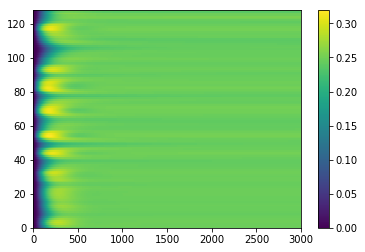

In [317]:
plt.pcolormesh(p_all[0,10].T)
plt.colorbar()

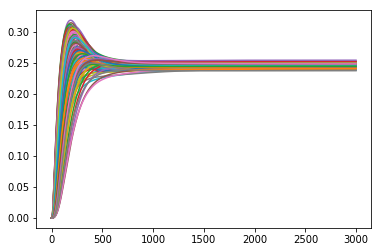

In [318]:
plt.plot(p_all[0,10,:,:])
plt.show()

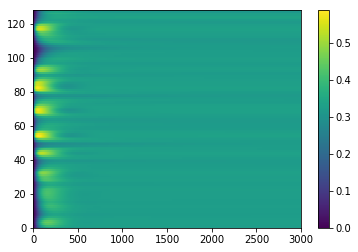

In [319]:
plt.pcolormesh(r_ipsi[0,10,:].T)
# plt.plot(r_ipsi[0,10,:,:])
plt.colorbar()

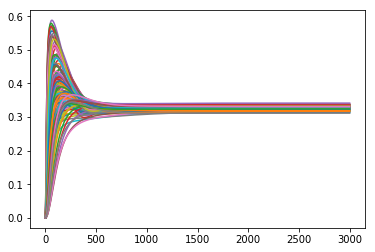

In [320]:
plt.plot(r_ipsi[0,10,:,:])
plt.show()

## Single Sound Comparison of Different Model Stages

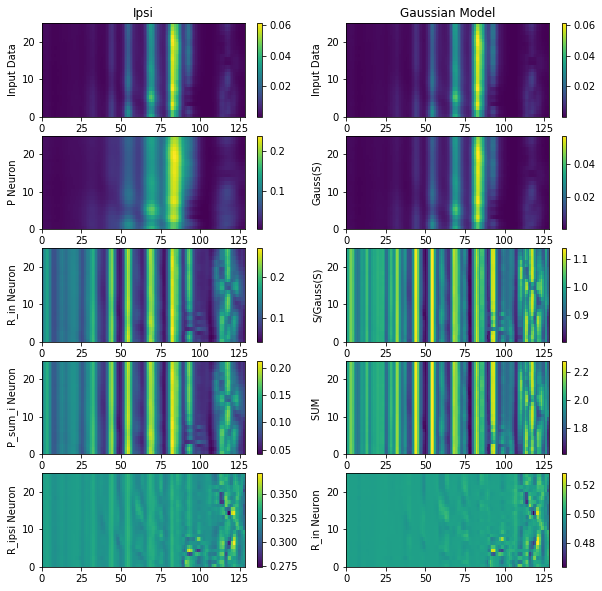

In [321]:
fig = plt.figure(figsize=(10,10))

axs = fig.subplots(nrows=5,ncols=2,squeeze=False)

# sounds_types = np.arange(0,20)

sound = 0
filter_sigma = 1

in_i = np.squeeze(input_i[sounds_types[sound],:,:])
in_c = np.squeeze(input_c[sounds_types[sound],:,:])

ax = axs[0,0]
ax.set_title('Ipsi')
tmp1 = in_i
a = ax.pcolormesh(tmp1)
ax.set_ylabel('Input Data')
fig.colorbar(a,ax=ax)

ax = axs[0,1]
ax.set_title('Gaussian Model')
tmp1 = in_i
a = ax.pcolormesh(tmp1)
ax.set_ylabel('Input Data')
fig.colorbar(a,ax=ax)



ax = axs[1,0]
tmp1 = np.squeeze(p_in_i[sound,:,-1:,:])
a = ax.pcolormesh(tmp1)
ax.set_ylabel('P Neuron')
fig.colorbar(a,ax=ax)

ax = axs[1,1]
tmp1 = in_i
tmp1 = gaussian_filter1d(tmp1, sigma=filter_sigma, mode='nearest', axis=1)
a = ax.pcolormesh(tmp1)
ax.set_ylabel('Gauss(S)')
fig.colorbar(a,ax=ax)



ax = axs[2,0]
tmp1 = np.squeeze(r_in_i[sound,:,-1:,:])
a = ax.pcolormesh(tmp1)
ax.set_ylabel('R_in Neuron')
fig.colorbar(a,ax=ax)

ax = axs[2,1]
tmp1 = in_i
tmp1 = tmp1/gaussian_filter1d(tmp1, sigma=filter_sigma, mode='nearest', axis=1)
a = ax.pcolormesh(tmp1)
ax.set_ylabel('S/Gauss(S)')
fig.colorbar(a,ax=ax)



ax = axs[3,0]
tmp1 = np.squeeze(p_sum_i[sound,:,-1:,:])
a = ax.pcolormesh(tmp1)
ax.set_ylabel('P_sum_i Neuron')
fig.colorbar(a,ax=ax)

ax = axs[3,1]
tmp1 = in_i
tmp1 = tmp1/gaussian_filter1d(tmp1, sigma=filter_sigma, mode='nearest', axis=1)

tmp2 = in_c
tmp2 = tmp2/gaussian_filter1d(tmp2, sigma=filter_sigma, mode='nearest', axis=1)
a = ax.pcolormesh((tmp1+tmp2))
ax.set_ylabel('SUM ')
fig.colorbar(a,ax=ax)



ax = axs[4,0]
tmp1 = (np.squeeze(r_ipsi[sound,:,-1:,:]))
a = ax.pcolormesh(tmp1)
ax.set_ylabel('R_ipsi Neuron')
fig.colorbar(a,ax=ax)

ax = axs[4,1]
tmp1 = in_i
tmp1 = tmp1/gaussian_filter1d(tmp1, sigma=filter_sigma, mode='nearest', axis=1)

tmp2 = in_c
tmp2 = tmp2/gaussian_filter1d(tmp2, sigma=filter_sigma, mode='nearest', axis=1)
a = ax.pcolormesh(tmp1/(tmp1+tmp2))
ax.set_ylabel('R_in Neuron')
fig.colorbar(a,ax=ax)



plt.show()


## Comparison of all Sounds

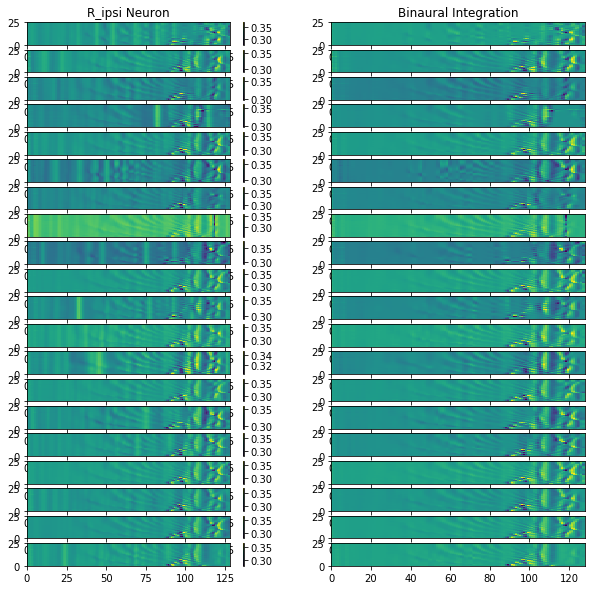

In [322]:
fig = plt.figure(figsize=(10,10))

axs = fig.subplots(nrows=len(sounds_types),ncols=2,squeeze=False)


for i_sounds,sound in enumerate(sounds_types):

    in_i = np.squeeze(input_i[sound,:,:])
    in_c = np.squeeze(input_c[sound,:,:])

    ax = axs[i_sounds,0]
    tmp1 = np.squeeze(r_ipsi[i_sounds,:,-1:,:])
    a = ax.pcolormesh(tmp1)
    if i_sounds == 0:
        ax.set_title('R_ipsi Neuron')
    fig.colorbar(a,ax=ax)

    ax = axs[i_sounds,1]
    if i_sounds == 0:
        ax.set_title('Binaural Integration')
    tmp1 = in_i
    tmp1 = tmp1/gaussian_filter1d(tmp1, sigma=1, mode='nearest', axis=1)
    
    tmp2 = in_c
    tmp2 = tmp2/gaussian_filter1d(tmp2, sigma=1, mode='nearest', axis=1)
    a = ax.pcolormesh(tmp1/(tmp1+tmp2))
#     fig.colorbar(a,ax=ax)



plt.show()

## Averaged Map

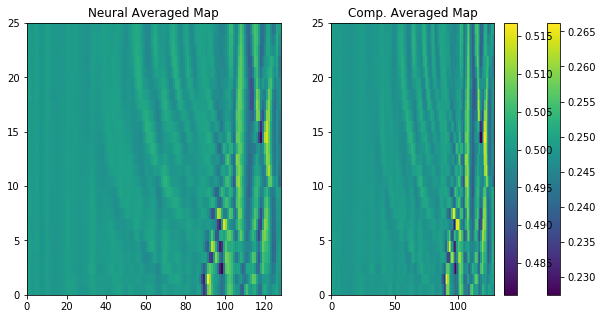

In [315]:
all_maps = np.zeros((len(sounds_types),len(elevations),freq_bands))
all_maps_neural = np.zeros((len(sounds_types),len(elevations),freq_bands))


for i_sounds,sound in enumerate(sounds_types):

    in_i = np.squeeze(input_i[sound,:,:])
    in_c = np.squeeze(input_c[sound,:,:])

    # Neural Map
    tmp1 = np.squeeze(r_ipsi[i_sounds,:,-1:,:])
    all_maps_neural[i_sounds,:,:] = tmp1


    # Comp Map
    tmp1 = in_i
    tmp1 = tmp1/gaussian_filter1d(tmp1, sigma=1, mode='nearest', axis=1)
    
    tmp2 = in_c
    tmp2 = tmp2/gaussian_filter1d(tmp2, sigma=1, mode='nearest', axis=1)
    tmp3 = tmp1/(tmp1+tmp2)
    all_maps[i_sounds,:,:] = tmp3



fig = plt.figure(figsize=(10,5))

axs = fig.subplots(nrows=1,ncols=2,squeeze=False)

ax = axs[0,0]
ax.set_title('Neural Averaged Map')
tmp = np.mean(all_maps_neural,axis=0)
c = ax.pcolormesh(tmp)
plt.colorbar(c)

ax = axs[0,1]
ax.set_title('Comp. Averaged Map')
tmp = np.mean(all_maps,axis=0)
c = ax.pcolormesh(tmp)
plt.colorbar(c)



plt.show()